### Purpose

The intent of this notebook is to serve as a rapid testing ground for new utilities. Any logic written here should migrate to the src/ directory as proper functions.

#### Import and Constants

In [1]:
from datetime import timedelta
from typing import List, Union

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.core.generic import NDFrame  # This is the generic type that encompasses Series and DataFrame
from scipy.ndimage import uniform_filter1d

number = Union[float, int]               # Something like this should be part of the standard library IMO

# Column names
DATE = "date"
WORKOUT_TYPE = "workout_type"
DATA_DURATION = "duration(HH:mm:ss)"     # This is the human-readable version -- it'll be dropped during processing
DURATION = "duration(s)"                 # Convert the human-readable durations to seconds for computational simplicity
DISTANCE = "distance(km)"
STEPS = "steps"
ELEVATION = "elevation(m)"
AVG_HEART_RATE = "avg_heart_rate"
MAX_HEART_RATE = "max_heart_rate"
NOTES = "notes"
LOCATION = "location"
EXERCISE = "exercise"
REPS = "reps"
WEIGHT = "weight(lbs)"
RATING = "rating"

#### Load Data

In [2]:
cardio_workouts = pd.read_csv("../data/cardio_workouts.csv")
weight_training_workouts = pd.read_csv("../data/weight_training_workouts.csv")
travel_days = pd.read_csv("../data/travel_days.csv")
weight_training_sets = pd.read_csv("../data/weight_training_sets.csv")

# Convert dates and times to proper types
for df in [cardio_workouts, weight_training_workouts, travel_days, weight_training_sets]:
    df[DATE] = pd.to_datetime(df[DATE])
    if DATA_DURATION in df:
        df[DATA_DURATION] = pd.to_timedelta(df[DATA_DURATION])
        df[DATA_DURATION] = df[DATA_DURATION].apply(lambda x: int(x.total_seconds()))
        df.rename(columns={DATA_DURATION: DURATION}, inplace=True)
    if NOTES in df:
        df[NOTES] = df[NOTES].fillna("")

# Will be used to pad all datasets to have consistent dates
all_dates = pd.concat([cardio_workouts[DATE], weight_training_workouts[DATE], travel_days[DATE]])

# Filling in a workout type for travel days
travel_days[WORKOUT_TYPE] = "Travel"

#### Transform

In [3]:
def join_with_comma(items: List[str]):
    """Wrapper function to join a list of strs with commas"""
    return ",".join(items)

def det_workout_type(joined_workout_types: str):
    """Determines the workout type given all of the comma-joined workout types for a given day."""
    result = ""
    for w_type in joined_workout_types.split(","):
        if not result:
            result = w_type
        if result and w_type != result:
            return "Mixed"
    return result

# Initialize the dataframe including all dates spanning the range of the data (rest days are missing in the workout data)
all_workouts = pd.DataFrame()
all_workouts[DATE] = pd.date_range(all_dates.min(), all_dates.max())
all_workouts = all_workouts.set_index(DATE)

# Populate the total daily workout duration
total_durations = pd.concat([
    weight_training_workouts.groupby(DATE)[DURATION].agg(sum),
    cardio_workouts.groupby(DATE)[DURATION].agg(sum),
    travel_days.groupby(DATE)[DURATION].agg(sum),
]).groupby(DATE).agg(sum)
total_durations.index = pd.DatetimeIndex(total_durations.index)
total_durations = total_durations.reindex(all_workouts.index, fill_value=0)
all_workouts[DURATION] = total_durations

# Populate the workout types (there can be more than one per day or rest days, this smooths that out)
workout_types = pd.concat([
    weight_training_workouts.groupby(DATE)[WORKOUT_TYPE].agg(join_with_comma),
    cardio_workouts.groupby(DATE)[WORKOUT_TYPE].agg(join_with_comma),
    travel_days.groupby(DATE)[WORKOUT_TYPE].agg(join_with_comma),
]).groupby(DATE).agg(join_with_comma)
workout_types = workout_types.apply(det_workout_type)
workout_types.index = pd.DatetimeIndex(workout_types.index)
workout_types = workout_types.reindex(all_workouts.index, fill_value="Rest Day")
all_workouts[WORKOUT_TYPE] = workout_types
del workout_types

all_workouts = all_workouts.reset_index()

#### Compute Trends

In [4]:
# n-day average over a week gives a sense of if I'm keeping above a relatively low baseline of 150 minutes/week
MIN_DAILY_ACTIVE_MINUTES = 22.5  # Weekly is 150, this is about 150/7
N_DAYS_TO_AVG = 8
n_day_avg_workout_duration = uniform_filter1d(all_workouts[DURATION], size=N_DAYS_TO_AVG)

# TODO Compute other trends:
# * linear regression on weight (first that data needs to be imported of course)
# * logarithmic trendline on resting heartrate (also after importing this data)

#### Build Visuals

In [5]:
# TODO Build at least these visuals:
# * Weight (plotted w/ linear regression trendline)
# * Resting heartrate (plotted w/ logarithmic trendline)
# * Workout frequency (plotted w/ N day running average)
# * Strength Metrics (PB + 10-rep; format TBD, likely better as two separate graphs or perhaps grouped by workout)
#    - Ideally: drop-down menu to select between various workouts, each plots its PB and 10-rep over time
# * Walking data (max distance, max elevation gain, max duration, pace graph)

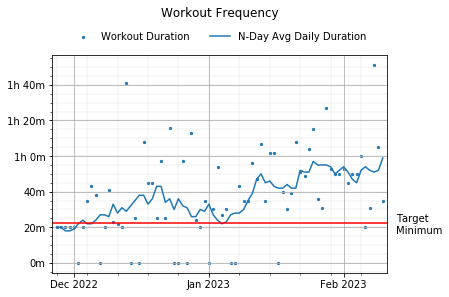

In [28]:
def convert_pd_to_np(obj: NDFrame) -> np.ndarray:
    return np.array(obj)[:, None]

def convert_mins_to_hour_mins(mins: number, _) -> str:
    if mins < 60:
        return f"{int(mins)}m"
    hours, mins = int(mins // 60), int(mins % 60)
    return f"{hours}h {mins}m"

### Utility function, not used in main path ###
def show_gcf_corners(plot: plt):
    plot.gcf().text(0, 0, "x")
    plot.gcf().text(1, 0, "x")
    plot.gcf().text(0, 1, "x")
    plot.gcf().text(1, 1, "x")

RIGHT_OF_AXIS_X_COORD = 0.92
NON_GRAPH_GCF_PERCENT = 0.06

# Draw the main graph contents and setup the figure/axes
fig, ax = plt.subplots()
workout_durations_mins = all_workouts[DURATION] // 60
plt.scatter(
    all_workouts[DATE],
    workout_durations_mins,
    s=5,
    label="Workout Duration",
)
plt.plot(
    convert_pd_to_np(all_workouts[DATE]),
    convert_pd_to_np(n_day_avg_workout_duration // 60),
    label="N-Day Avg Daily Duration",
)

# Delineate the ideal minimum daily exercise threshold as a horizontal reference line
plt.axhline(y=MIN_DAILY_ACTIVE_MINUTES, color='r', linestyle='-')
y_percent_min_daily_active = MIN_DAILY_ACTIVE_MINUTES / max(workout_durations_mins)
y_pos = y_percent_min_daily_active + NON_GRAPH_GCF_PERCENT
plt.gcf().text(RIGHT_OF_AXIS_X_COORD, y_pos, "Target\nMinimum")

# Set up axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.SU))
plt.xlim(
    all_workouts[DATE][0] - timedelta(days=1),
    all_workouts[DATE].tail(1) + timedelta(days=1)
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(convert_mins_to_hour_mins))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
plt.grid(visible=True)
plt.grid(visible=True, which="minor", axis="y", linestyle="--", linewidth="0.25")
plt.grid(visible=True, which="minor", axis="x", linestyle="--", linewidth="0.25")

# Add in the surrounding information
ABOVE_TABLE = 1.15
plt.title("Workout Frequency", y=ABOVE_TABLE)
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = handles[::-1], labels[::-1]
plt.legend(handles, labels, bbox_to_anchor=(0.5, ABOVE_TABLE), loc='upper center', frameon=False, ncol=2)
plt.show()